<a href="https://colab.research.google.com/github/iamviji/project/blob/master/End2EndOneHotQPSK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!rm -rf project
!git clone https://github.com/iamviji/project.git
!ls
!ls project
!pip install pyldpc
!pip install scikit-commpy



Cloning into 'project'...
remote: Enumerating objects: 172, done.
remote: Counting objects: 100% (172/172), done.
remote: Compressing objects: 100% (166/166), done.
remote: Total 172 (delta 71), reused 18 (delta 3), pack-reused 0
Receiving objects: 100% (172/172), 11.80 MiB | 11.12 MiB/s, done.
Resolving deltas: 100% (71/71), done.
project  sample_data
End2End8PSK.ipynb	    MainModelModCoding.ipynb
End2EndOneHotQPSK.ipynb     MainModelOneHotMethod.ipynb
End2EndQPSK.ipynb	    MainModelOneHotMethodSoftMax.ipynb
MainModel.ipynb		    MainModelWithSingleBERTraining.ipynb
MainModelKeras.ipynb	    README.md
MainModelKerasOneHot.ipynb  util.py
     |████████████████████████████████| 1.1MB 2.7MB/s 
  Created wheel for pyldpc: filename=pyldpc-0.7.9-cp36-none-any.whl size=14306 sha256=e5718893b1c5ca11551154b9a6f77d589c62e191f16c1667f1f94db64ad1d2a2
  Stored in directory: /root/.cache/pip/wheels/47/7a/10/e94058ba8b0b6d98bf2719226d18d3dd6056525ad7b984c068
Successfully built pyldpc
     |███████████

In [2]:
import pyldpc
import commpy
import numpy 
import time
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior ()

Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
SNR_BEGIN = 0
SNR_END = 10
SNR_STEP_SIZE = 0.5
CHANEL_SIZE = 18
NUM_OF_INPUT_MESSAGE = 1000
LDPC_MAX_ITER = 100
num_parity_check = 3
num_bits_in_parity_check = 6 
input_message_length =  0 # Caculated by channel encoder and initialized later

In [4]:
def timer_update(i,current,time_tot,tic_incr=500):
    last = current
    current = time.time()
    t_diff = current-last
    print('SNR: {:04.3f} - Iter: {} - Last {} iterations took {:03.2f}s'.format(snr,i+1,tic_incr,t_diff))
    return time_tot + t_diff

def Snr2Sigma(snr):
  sigma = 10 ** (- snr / 20)
  return sigma

def pyldpc_encode (CodingMatrix, message):
  rng = pyldpc.utils.check_random_state(seed=None)
  d = pyldpc.utils.binaryproduct(CodingMatrix, message)
  encoded_message = (-1) ** d
  return encoded_message

def pyldpc_decode (ParityCheckMatrix, CodingMatrix, message, snr, maxiter):
  decoded_msg = pyldpc.decode(ParityCheckMatrix, message, snr, maxiter)
  out_message = pyldpc.get_message(CodingMatrix, decoded_msg)
  return out_message

awgn_channel_input = tf.compat.v1.placeholder(tf.float64, [CHANEL_SIZE])
awgn_noise_std_dev = tf.placeholder(tf.float64)
awgn_noise = tf.random.normal(tf.shape(awgn_channel_input), stddev=awgn_noise_std_dev, dtype=tf.dtypes.float64)
awgn_channel_output = tf.add(awgn_channel_input, awgn_noise)

init = tf.global_variables_initializer ()
sess = tf.Session ()
sess.run(init)

def AWGNChannelOutput (xx, snr , s):
  sigma = Snr2Sigma (snr)
  awgn_channel_output_message = s.run ([awgn_channel_output], feed_dict={noise_std_dev:sigma, channel_input:xx})
  return awgn_channel_output_message

In [5]:

ParityCheckMatrix, CodingMatrix = pyldpc.make_ldpc(CHANEL_SIZE, num_parity_check, num_bits_in_parity_check, systematic=True, sparse=True)
input_message_length = CodingMatrix.shape[1]
print ("input_message_size=", input_message_length, "channel_size=",CHANEL_SIZE)
print ("input_message_size=", CodingMatrix.shape[1], "channel_size=",CodingMatrix.shape[0])
input_message = numpy.random.randint(2, size=(NUM_OF_INPUT_MESSAGE,input_message_length))
print (input_message)

input_message_size= 11 channel_size= 18
input_message_size= 11 channel_size= 18
[[1 1 0 ... 0 1 1]
 [1 0 1 ... 1 0 0]
 [1 0 0 ... 0 1 0]
 ...
 [0 0 0 ... 0 1 0]
 [1 1 0 ... 1 1 1]
 [0 0 1 ... 1 0 0]]


This section tries to compare BER and Time performance of PYLDPC in following 3 cases
1. SNR Noise function provided in encoder function of pyldpc library (pyldpc.encode)
2. SNR Noise function provided by commpy library (commpy.channels.awgn) 
3. SNR Noise function implemented using tensorflow 

In [6]:
# Here I am using tensor flow based AWGN, to make sure that effect of it is same as AWGN
output_display_counter = NUM_OF_INPUT_MESSAGE/4
ber_per_iter_tensor  = numpy.array(())
times_per_iter_tensor = numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    encoded_message = pyldpc_encode (CodingMatrix, input_message[i])
    sigma = Snr2Sigma (snr)
    awgn_channel_output_message = sess.run ([awgn_channel_output], feed_dict={awgn_noise_std_dev:sigma, awgn_channel_input:encoded_message})[0]
    decoded_message = pyldpc_decode(ParityCheckMatrix, CodingMatrix, awgn_channel_output_message, snr, LDPC_MAX_ITER)
    if abs(decoded_message-input_message[i]).sum() != 0 :
      #print ("count=",abs(decoded_message-input_message[i]).sum())
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  ber_per_iter_tensor=numpy.append(ber_per_iter_tensor ,ber)
  times_per_iter_tensor=numpy.append(times_per_iter_tensor, total_time)

/usr/local/lib/python3.6/dist-packages/pyldpc/decoder.py:63: UserWarning: Decoding stopped before convergence. You may want
                       to increase maxiter
  to increase maxiter""")


SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 1.79s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 3.45s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 4.95s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 6.63s
SNR: 0.000:
 -> BER: 0.58
 -> Total Time: 16.83s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 1.33s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 2.59s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 4.05s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 5.56s
SNR: 0.500:
 -> BER: 0.53
 -> Total Time: 13.52s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 1.14s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 2.29s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 3.45s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 4.54s
SNR: 1.000:
 -> BER: 0.42
 -> Total Time: 11.41s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.99s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 1.87s
SNR: 1.500 - Iter: 750 - Last 250.0 it

In [7]:
# Here I am using commpy based AWGN 
output_display_counter = NUM_OF_INPUT_MESSAGE/4
ber_per_iter_awgn  = numpy.array(())
times_per_iter_awgn = numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    encoded_message = pyldpc_encode (CodingMatrix, input_message[i])
    awgn_channel_output_message = commpy.channels.awgn(encoded_message, snr)
    decoded_message = pyldpc_decode(ParityCheckMatrix, CodingMatrix, awgn_channel_output_message, snr, LDPC_MAX_ITER)
    if abs(decoded_message-input_message[i]).sum() != 0 :
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  ber_per_iter_awgn=numpy.append(ber_per_iter_awgn ,ber)
  times_per_iter_awgn=numpy.append(times_per_iter_awgn, total_time)

/usr/local/lib/python3.6/dist-packages/pyldpc/decoder.py:63: UserWarning: Decoding stopped before convergence. You may want
                       to increase maxiter
  to increase maxiter""")


SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 1.52s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 3.14s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 4.72s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 6.22s
SNR: 0.000:
 -> BER: 0.59
 -> Total Time: 15.59s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 1.39s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 2.79s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 4.13s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 5.45s
SNR: 0.500:
 -> BER: 0.54
 -> Total Time: 13.76s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 1.16s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 2.29s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 3.39s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 4.39s
SNR: 1.000:
 -> BER: 0.43
 -> Total Time: 11.24s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.83s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 1.58s
SNR: 1.500 - Iter: 750 - Last 250.0 it

In [8]:
# Here I am using tensor flow based AWGN, to make sure that effect of it is same as AWGN
output_display_counter = NUM_OF_INPUT_MESSAGE/4
ber_per_iter_pyldpc  = numpy.array(())
times_per_iter_pyldpc = numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    encoded_message = pyldpc.encode (CodingMatrix, input_message[i], snr)
    awgn_channel_output_message = encoded_message
    decoded_message = pyldpc_decode(ParityCheckMatrix, CodingMatrix, awgn_channel_output_message, snr, LDPC_MAX_ITER)
    if abs(decoded_message-input_message[i]).sum() != 0 :
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  ber_per_iter_pyldpc=numpy.append(ber_per_iter_pyldpc ,ber)
  times_per_iter_pyldpc=numpy.append(times_per_iter_pyldpc, total_time)

/usr/local/lib/python3.6/dist-packages/pyldpc/decoder.py:63: UserWarning: Decoding stopped before convergence. You may want
                       to increase maxiter
  to increase maxiter""")


SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 1.53s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 3.17s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 4.63s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 6.18s
SNR: 0.000:
 -> BER: 0.59
 -> Total Time: 15.51s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 1.27s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 2.50s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 3.86s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 5.17s
SNR: 0.500:
 -> BER: 0.53
 -> Total Time: 12.80s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 1.14s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 2.11s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 3.14s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 4.32s
SNR: 1.000:
 -> BER: 0.44
 -> Total Time: 10.71s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.79s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 1.41s
SNR: 1.500 - Iter: 750 - Last 250.0 it

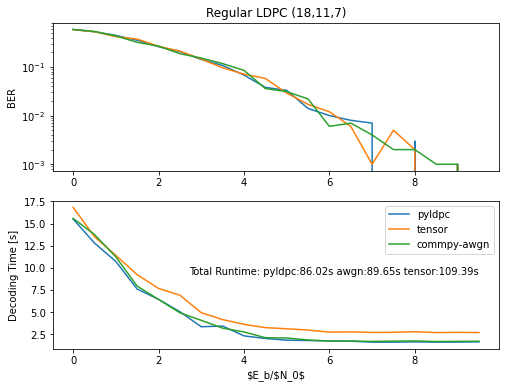

In [9]:
# Compare 3 AWGN(Tensorflow, CommPy, PYLDPC) Simulation on LDPC
import matplotlib.pyplot as plt
%matplotlib inline
snrs = numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(8,6))
ax1.semilogy(snrs,ber_per_iter_pyldpc,'', label="pyldpc") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_tensor,'', label="tensor") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_awgn,'', label="commpy-awgn") # plot BER vs SNR

ax1.set_ylabel('BER')
ax1.set_title('Regular LDPC ({},{},{})'.format(CHANEL_SIZE,input_message_length,CHANEL_SIZE-input_message_length))
ax2.plot(snrs,times_per_iter_pyldpc,'', label="pyldpc") # plot decode timing for different SNRs
ax2.plot(snrs,times_per_iter_tensor,'', label="tensor") # plot decode timing for different SNRs
ax2.plot(snrs,times_per_iter_awgn,'', label="commpy-awgn") # plot decode timing for different SNRs
ax2.set_xlabel('$E_b/$N_0$')
ax2.set_ylabel('Decoding Time [s]')
ax2.annotate('Total Runtime: pyldpc:{:03.2f}s awgn:{:03.2f}s tensor:{:03.2f}s'.format(numpy.sum(times_per_iter_pyldpc), 
            numpy.sum(times_per_iter_awgn), numpy.sum(times_per_iter_tensor)),
            xy=(1, 0.35), xycoords='axes fraction',
            xytext=(-20, 20), textcoords='offset pixels',
            horizontalalignment='right',
            verticalalignment='bottom')
plt.savefig('ldpc_ber_{}_{}.png'.format(CHANEL_SIZE,input_message_length))
plt.legend ()
plt.show()

<B>Conclussion:</B>
      It proved that tensorflow behaves similar to AWGN noise channel provided by pyldpc, commpy. But tensor flow based one takes adds little more time delay. This need to be offseted if we are comparing performance. 

In [10]:
class GetOutOfLoop( Exception ):
    pass

In [11]:
# 18/9 = 2 bit per symbol => QSPK
num_of_channel = 9
input_message_length = 11
encoder_output_length = 18

In [12]:
# Define Model 
from keras.layers.normalization import BatchNormalization

# input_message_length is initialized by ldpc encoder

num_hidden_1 = encoder_output_length
print ("input_message_length=", input_message_length)

lr_x = tf.placeholder(dtype=tf.float32,shape=[])
#batch_size_x = tf.placeholder(tf.int32,shape=[])
input_message_x_label = tf.placeholder("int32", [None], name="input_message_x_label")
input_message_x = tf.placeholder("float32", [None, 2**input_message_length], name="input_message_x")
awgn_noise_std_dev_x = tf.placeholder("float32", name ="awgn_noise_std_dev")
input_channel_x = tf.placeholder("float32", [None, num_of_channel * 2], name="input_channel_x")

weights = {
  "encoder_l1" : tf.Variable (tf.random_uniform([2**input_message_length, num_hidden_1], -1, 1), name="encoder_l1_weights"),
  "encoder_l2" : tf.Variable (tf.random_uniform([num_hidden_1, num_of_channel * 2], -1, 1), name="encoder_l2_weights"),
  "decoder_l1" : tf.Variable (tf.random_uniform([num_of_channel * 2, num_hidden_1], -1, 1), name="decoder_l1_weights"),
  "decoder_l2" : tf.Variable (tf.random_uniform([num_hidden_1, num_hidden_1], -1, 1), name="decoder_l3_weights"),
  "decoder_l3" : tf.Variable (tf.random_uniform([num_hidden_1, 2**input_message_length], -1, 1), name="decoder_l3_weights"),
  
}

biases = {
  "encoder_l1" : tf.Variable (tf.random_uniform([num_hidden_1], -1,1), name="encoder_l1_bias"),
  "encoder_l2" : tf.Variable (tf.random_uniform([num_of_channel * 2], -1,1), name="encoder_l2_bias"),
  "decoder_l1" : tf.Variable (tf.random_uniform([num_hidden_1], -1,1), name="decoder_l1_bias"),
  "decoder_l2" : tf.Variable (tf.random_uniform([num_hidden_1], -1,1), name="decoder_l2_bias"),
  "decoder_l3" : tf.Variable (tf.random_uniform([2**input_message_length], -1,1), name="decoder_l3_bias"),
}

def dl_encoder (x):
  layer_1 = tf.nn.tanh (tf.matmul(x, weights['encoder_l1']) + biases['encoder_l1'])
  layer_2 = (tf.matmul(layer_1, weights['encoder_l2']) + biases['encoder_l2'])
  #layer_2 = tf.round(layer_1)
  #layer_1 = BatchNormalization ()(layer_1)
  layer_3 =  layer_2 / tf.sqrt(tf.reduce_mean(tf.square(layer_2)))
  #layer_2 =  tf.nn.relu(layer_1)
  return layer_3

def dl_decoder (x):
  layer_1 = (tf.matmul(x, weights['decoder_l1']) + biases['decoder_l1'])
  layer_2 = tf.nn.tanh(tf.matmul(layer_1, weights['decoder_l2']) + biases['decoder_l2'])
  layer_3 = (tf.matmul(layer_2, weights['decoder_l3']) + biases['decoder_l3'])
  return layer_3

def awgn_layer(x):
  awgn_noise = tf.random.normal(tf.shape(x), stddev=awgn_noise_std_dev_x,  name="awgn_noise")
  awgn_channel_output = tf.add(x, awgn_noise, name ="x_and_noise")
  return awgn_channel_output


dl_encoder_output = dl_encoder(input_message_x)
dl_decoder_input = awgn_layer(dl_encoder_output)
#awgn_noise = tf.random.normal(tf.shape(dl_encoder_output), stddev=awgn_noise_std_dev,  name="awgn_noise")
#dl_decoder_input = tf.add(dl_encoder_output, awgn_noise, name ="x_and_noise")
dl_decoder_output = dl_decoder (dl_decoder_input)
dl_decoder_only_output = dl_decoder(input_channel_x)


#loss1 = tf.reduce_mean (-1 * (input_message_x*tf.log(dl_decoder_output) + (1 - input_message_x)*tf.log(1 - dl_decoder_output) ))
loss = tf.losses.sparse_softmax_cross_entropy(labels=input_message_x_label,logits=dl_decoder_output)
optimizer = tf.train.AdamOptimizer(learning_rate=lr_x).minimize (loss)

input_message_length= 11


In [13]:
import numpy
training_input_message = numpy.random.randint(2**input_message_length, size=(1,NUM_OF_INPUT_MESSAGE*10))
training_input_message_one_hot = numpy.zeros((training_input_message.size, 2**input_message_length))
training_input_message_one_hot[numpy.arange(training_input_message.size),training_input_message] = 1
print(training_input_message_one_hot)
print (training_input_message_one_hot.shape)
print (training_input_message.shape)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(10000, 2048)
(1, 10000)


In [14]:
batch_size = 500

# Training
train_init = tf.global_variables_initializer ()
train_sess = tf.Session ()
#0.8
epochs = 60
outer_ephocs = 1
display_step = 4
num_of_batches = training_input_message.shape[1] / batch_size
print ("batch_size:", batch_size, "num_of_batcches:", num_of_batches)
train_sess.run(train_init)
l = 0
lrate = 0.1
i = 0
snr_min = 9.5
snr_max = 10.5
snr_step_size = 0.5
max_iteration = epochs * num_of_batches * (snr_max - snr_min) / snr_step_size
print ("max iteration :",max_iteration,"num_of_batches:", num_of_batches)
try:
  for oe in range(outer_ephocs):
    for snr in (numpy.arange (0, 10, SNR_STEP_SIZE)):
    #for snr in (numpy.arange (snr_min, snr_max, SNR_STEP_SIZE)):
      sigma = 1.0*Snr2Sigma (7)
      print ("Training for SNR=", snr, " sigma=", sigma, "iteratin:", oe) 
      for e in range(epochs):
        for j in range (int(num_of_batches)):
          i = i + 1
          x_train_batch_one_hot = training_input_message_one_hot [j*batch_size:(j+1)*batch_size]
          x_train_batch_one_hot = x_train_batch_one_hot.astype("float32")
          x_train_batch_label = training_input_message.reshape(training_input_message.shape[1]) [j*batch_size:(j+1)*batch_size]        
          if (i < 100): 
            lr = 0.1
          elif(i < 200):
            lr = 0.1
          else:
            lr = 0.01 
          _, l = train_sess.run ([optimizer, loss], feed_dict={input_message_x:x_train_batch_one_hot, awgn_noise_std_dev_x:sigma, lr_x:lr, input_message_x_label:x_train_batch_label.astype("int32")})
          if i % display_step == 0:          
            print('Step %i: Minibatch Loss: %f' % (i, l ))
          if (l < 0.05 and snr >= 9): 
            print ("Loss=", l)
            raise GetOutOfLoop
except GetOutOfLoop:
  print("Early Stop")

Streaming output truncated to the last 5000 lines.
Step 4072: Minibatch Loss: 0.737628
Step 4076: Minibatch Loss: 0.712772
Step 4080: Minibatch Loss: 0.766457
Step 4084: Minibatch Loss: 0.632656
Step 4088: Minibatch Loss: 0.679766
Step 4092: Minibatch Loss: 0.721567
Step 4096: Minibatch Loss: 0.728920
Step 4100: Minibatch Loss: 0.650855
Step 4104: Minibatch Loss: 0.634792
Step 4108: Minibatch Loss: 0.675036
Step 4112: Minibatch Loss: 0.741859
Step 4116: Minibatch Loss: 0.602824
Step 4120: Minibatch Loss: 0.592738
Step 4124: Minibatch Loss: 0.604678
Step 4128: Minibatch Loss: 0.714445
Step 4132: Minibatch Loss: 0.681293
Step 4136: Minibatch Loss: 0.608762
Step 4140: Minibatch Loss: 0.719025
Step 4144: Minibatch Loss: 0.684059
Step 4148: Minibatch Loss: 0.663545
Step 4152: Minibatch Loss: 0.706212
Step 4156: Minibatch Loss: 0.650150
Step 4160: Minibatch Loss: 0.664746
Step 4164: Minibatch Loss: 0.603618
Step 4168: Minibatch Loss: 0.692713
Step 4172: Minibatch Loss: 0.734842
Step 4176: Mi

In [15]:
awgn_channel_input = tf.compat.v1.placeholder(tf.float64, [num_of_channel * 2])
awgn_noise_std_dev = tf.placeholder(tf.float64)
awgn_noise = tf.random.normal(tf.shape(awgn_channel_input), stddev=awgn_noise_std_dev, dtype=tf.dtypes.float64)
awgn_channel_output = tf.add(awgn_channel_input, awgn_noise)

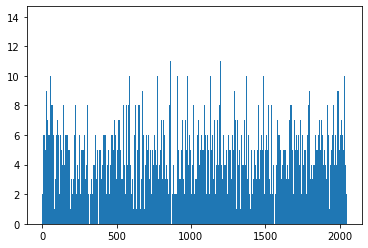

In [16]:
#input_message_length=8
#training_input_message = numpy.random.randint(2, size=(NUM_OF_INPUT_MESSAGE*10,input_message_length))
#training_input_message_decimal = row_bits2int(training_input_message)
#uniqueValues, indicesList = numpy.unique(training_input_message_decimal, return_index=True)
x_axis = numpy.arange(0,2**input_message_length)
#y_axis = row_bits2int(training_input_message)
#x=numpy.histogram(training_input_message_decimal,bins = x_axis) 
plt.hist(training_input_message[0], bins = x_axis) 
plt.show()

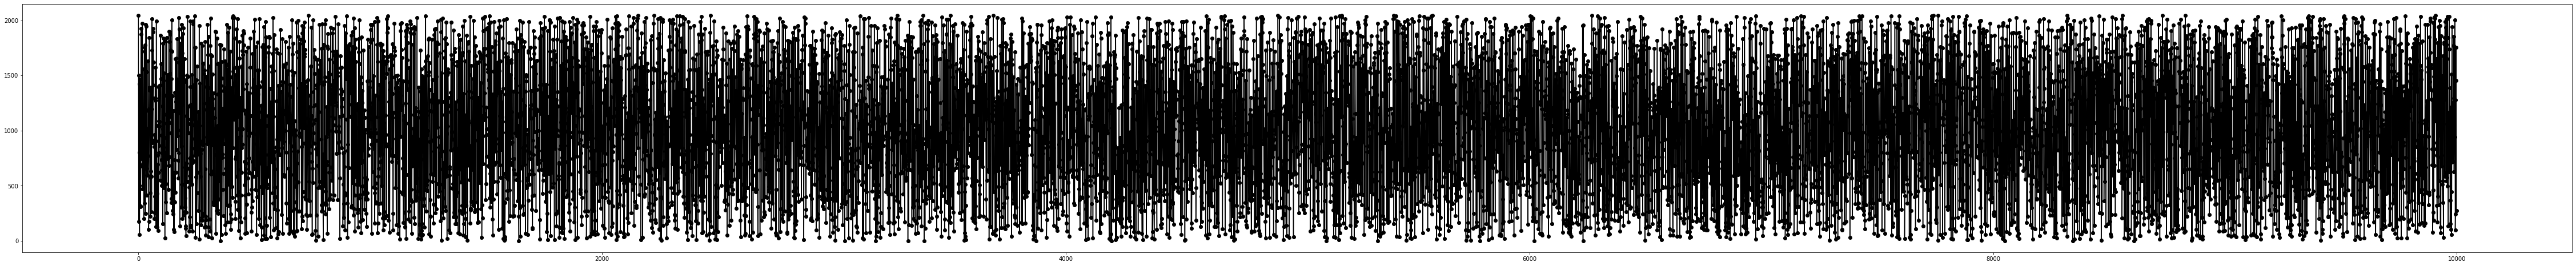

In [17]:
x_axis = numpy.arange(0,NUM_OF_INPUT_MESSAGE*10)
plt.figure(figsize=(80, 8))
plt.plot(x_axis[:-1],training_input_message[0][:-1], '-ok')
#print (x_axis[:100])
#print(training_input_message_decimal[:100])

In [18]:
# Here I am using trained model
output_display_counter = NUM_OF_INPUT_MESSAGE/4
ber_per_iter_dl_tensor  = numpy.array(())
times_per_iter_dl_tensor = numpy.array(())

channel_in = []
channel_out = []
data_category = []
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  lrate = 0.001
  sigma = Snr2Sigma (snr)
  for i in range (NUM_OF_INPUT_MESSAGE):
    input_message_xx = training_input_message_one_hot [i:i+1]
    data_category.append(training_input_message[0][i])
    input_message_xx = input_message_xx.astype("float32")
    #,input_message_x_label:training_input_message [i]
    encoded_message = train_sess.run ([dl_encoder_output], feed_dict={input_message_x:input_message_xx })
    encoded_message = encoded_message[0][0]
    #encoded_message = numpy.around(encoded_message[0][0]> 0).astype(int)
    #print (encoded_message[0][0])
    channel_in.append(encoded_message)
    awgn_channel_output_message = sess.run ([awgn_channel_output], feed_dict={awgn_noise_std_dev:sigma, awgn_channel_input:encoded_message})
    channel_out.append(awgn_channel_output_message[0])
    #print (awgn_channel_output_message)
    decoded_message = train_sess.run ([dl_decoder_only_output], feed_dict={input_channel_x:awgn_channel_output_message})
    #print ("input", input_message[i])
    #decoded_message = numpy.around(decoded_message[0][0]> 0).astype(int)
    #rint ("output", decoded_message)
    #print ("output", numpy.argmax(training_input_message_one_hot[i]), numpy.argmax(decoded_message[0][0]))
    if (numpy.argmax(training_input_message_one_hot[i]) != numpy.argmax(decoded_message[0][0])):
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  ber_per_iter_dl_tensor=numpy.append(ber_per_iter_dl_tensor ,ber)
  times_per_iter_dl_tensor=numpy.append(times_per_iter_dl_tensor, total_time)

SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 0.40s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 0.68s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 0.96s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 1.24s
SNR: 0.000:
 -> BER: 0.70
 -> Total Time: 3.28s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 0.28s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 0.55s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 0.83s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 1.10s
SNR: 0.500:
 -> BER: 0.68
 -> Total Time: 2.75s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 0.28s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 0.56s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 0.83s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 1.11s
SNR: 1.000:
 -> BER: 0.60
 -> Total Time: 2.78s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.28s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 0.57s
SNR: 1.500 - Iter: 750 - Last 250.0 itera

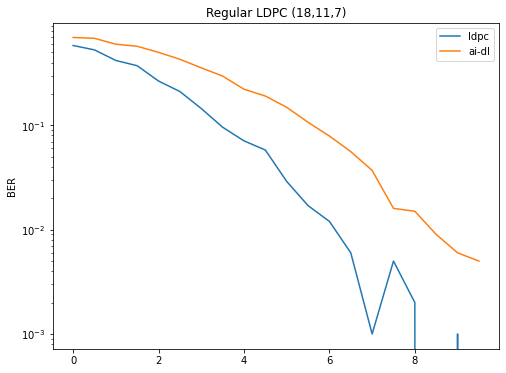

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
snrs = numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)
fig, (ax1) = plt.subplots(1,1,figsize=(8,6))
ax1.semilogy(snrs,ber_per_iter_tensor,'', label="ldpc") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_dl_tensor,'', label="ai-dl") # plot BER vs SNR
ax1.set_ylabel('BER')
ax1.set_title('Regular LDPC ({},{},{})'.format(num_of_channel * 2,input_message_length,num_of_channel * 2 - input_message_length))
#ax2.plot(snrs,times_per_iter_pyldpc,'', label="pyldpc") # plot decode timing for different SNRs
#ax2.plot(snrs,times_per_iter_tensor,'', label="tensor") # plot decode timing for different SNRs
#ax2.plot(snrs,times_per_iter_awgn,'', label="commpy-awgn") # plot decode timing for different SNRs
#ax2.set_xlabel('$E_b/$N_0$')
#ax2.set_ylabel('Decoding Time [s]')
#ax2.annotate('Total Runtime: pyldpc:{:03.2f}s awgn:{:03.2f}s tensor:{:03.2f}s'.format(numpy.sum(times_per_iter_pyldpc), 
#            numpy.sum(times_per_iter_awgn), numpy.sum(times_per_iter_tensor)),
#            xy=(1, 0.35), xycoords='axes fraction',
#            xytext=(-20, 20), textcoords='offset pixels',
#            horizontalalignment='right',
#            verticalalignment='bottom')
plt.savefig('ldpc_ber_{}_{}.png'.format(num_of_channel * 2,input_message_length))
plt.legend ()
plt.show()

In [20]:
from sklearn.manifold import TSNE
import pandas as pd
import seaborn

channel_in_embedded = TSNE(n_components=2).fit_transform(channel_in)

tsne_df = pd.DataFrame({'X':channel_in_embedded[:,0],
                        'Y':channel_in_embedded[:,1],
                        'value':data_category})

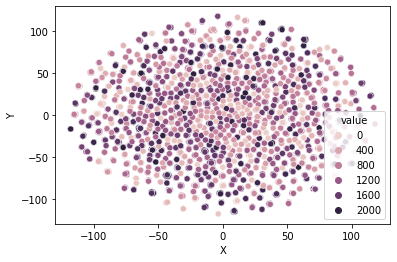

In [21]:
#seaborn.scatterplot(channel_in_embedded[:,0], channel_in_embedded[:,1],hue=data_category, legend='full', palette=['purple','red','orange','brown','blue','dodgerblue','green','lightgreen','darkcyan', 'black'])
#print (data_category)
#palette = seaborn.color_palette("bright", 2**input_message_length)

seaborn.scatterplot(x="X", y="Y", hue="value",  data=tsne_df)


In [22]:
from sklearn.manifold import TSNE
import pandas as pd
import seaborn

channel_out_embedded = TSNE(n_components=2).fit_transform(channel_out)

out_tsne_df = pd.DataFrame({'X':channel_out_embedded[:,0],
                        'Y':channel_out_embedded[:,1],
                        'value':data_category})

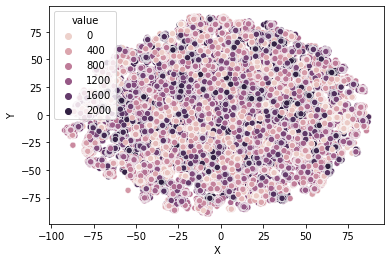

In [23]:
seaborn.scatterplot(x="X", y="Y", hue="value",  data=out_tsne_df)


In [24]:
import numpy
testing_input_message = numpy.random.randint(2**input_message_length, size=(1,NUM_OF_INPUT_MESSAGE))
testing_input_message_one_hot = numpy.zeros((testing_input_message.size, 2**input_message_length))
testing_input_message_one_hot[numpy.arange(testing_input_message.size),testing_input_message] = 1
print(testing_input_message_one_hot)
print (testing_input_message_one_hot.shape)
print (testing_input_message.shape)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(1000, 2048)
(1, 1000)


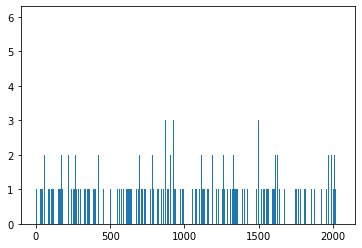

In [25]:
x_axis = numpy.arange(0,2**input_message_length)
plt.hist(testing_input_message[0], bins = x_axis) 
plt.show()

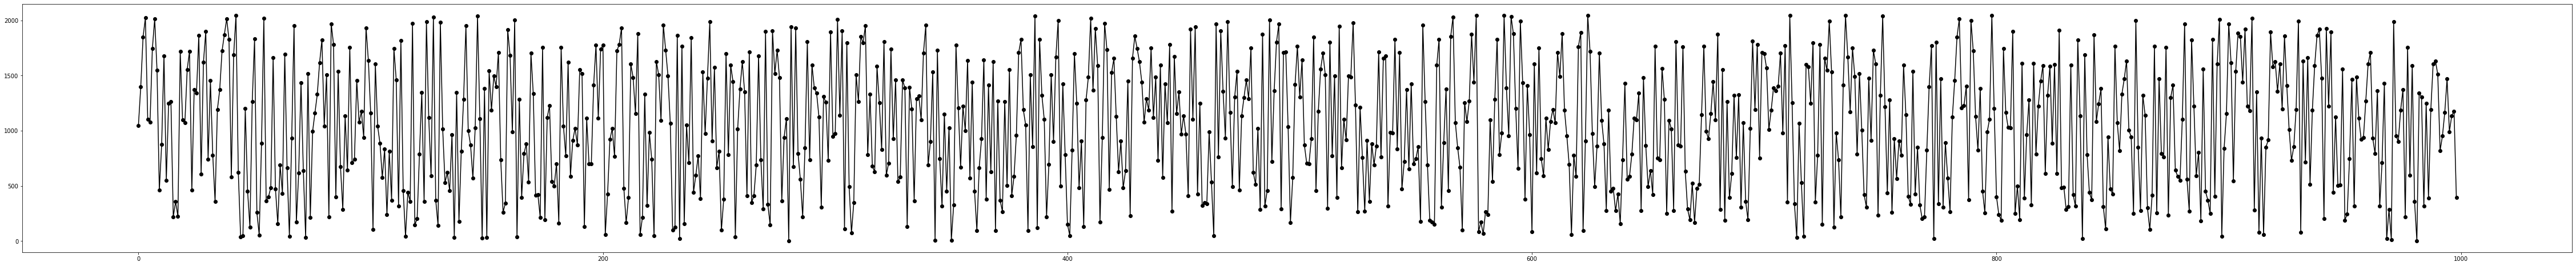

In [26]:
x_axis = numpy.arange(0,NUM_OF_INPUT_MESSAGE)
plt.figure(figsize=(80, 8))
plt.plot(x_axis[:-1],testing_input_message[0][:-1], '-ok')


In [27]:
# Here I am using trained model
output_display_counter = NUM_OF_INPUT_MESSAGE/4
ber_per_iter_dl_tensor  = numpy.array(())
times_per_iter_dl_tensor = numpy.array(())

for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  lrate = 0.001
  sigma = Snr2Sigma (snr)
  for i in range (NUM_OF_INPUT_MESSAGE):
    input_message_xx = training_input_message_one_hot [i:i+1]
    input_message_xx = input_message_xx.astype("float32")
    #,input_message_x_label:training_input_message [i]
    encoded_message = train_sess.run ([dl_encoder_output], feed_dict={input_message_x:input_message_xx })
    encoded_message = encoded_message[0][0]
    #encoded_message = numpy.around(encoded_message[0][0]> 0).astype(int)
    #print (encoded_message[0][0])
    awgn_channel_output_message = sess.run ([awgn_channel_output], feed_dict={awgn_noise_std_dev:sigma, awgn_channel_input:encoded_message})
    #print (awgn_channel_output_message)
    decoded_message = train_sess.run ([dl_decoder_only_output], feed_dict={input_channel_x:awgn_channel_output_message})
    #print ("input", input_message[i])
    #decoded_message = numpy.around(decoded_message[0][0]> 0).astype(int)
    #rint ("output", decoded_message)
    #print ("output", numpy.argmax(training_input_message_one_hot[i]), numpy.argmax(decoded_message[0][0]))
    if (numpy.argmax(training_input_message_one_hot[i]) != numpy.argmax(decoded_message[0][0])):
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  ber_per_iter_dl_tensor=numpy.append(ber_per_iter_dl_tensor ,ber)
  times_per_iter_dl_tensor=numpy.append(times_per_iter_dl_tensor, total_time)

SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 0.35s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 0.65s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 0.95s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 1.24s
SNR: 0.000:
 -> BER: 0.71
 -> Total Time: 3.19s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 0.29s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 0.57s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 0.85s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 1.14s
SNR: 0.500:
 -> BER: 0.66
 -> Total Time: 2.84s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 0.29s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 0.58s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 0.89s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 1.18s
SNR: 1.000:
 -> BER: 0.64
 -> Total Time: 2.94s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.27s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 0.56s
SNR: 1.500 - Iter: 750 - Last 250.0 itera

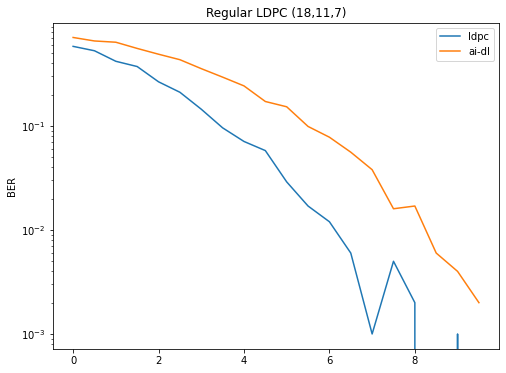

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline
snrs = numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)
fig, (ax1) = plt.subplots(1,1,figsize=(8,6))
ax1.semilogy(snrs,ber_per_iter_tensor,'', label="ldpc") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_dl_tensor,'', label="ai-dl") # plot BER vs SNR
ax1.set_ylabel('BER')
ax1.set_title('Regular LDPC ({},{},{})'.format(num_of_channel * 2,input_message_length,num_of_channel * 2 - input_message_length))
#ax2.plot(snrs,times_per_iter_pyldpc,'', label="pyldpc") # plot decode timing for different SNRs
#ax2.plot(snrs,times_per_iter_tensor,'', label="tensor") # plot decode timing for different SNRs
#ax2.plot(snrs,times_per_iter_awgn,'', label="commpy-awgn") # plot decode timing for different SNRs
#ax2.set_xlabel('$E_b/$N_0$')
#ax2.set_ylabel('Decoding Time [s]')
#ax2.annotate('Total Runtime: pyldpc:{:03.2f}s awgn:{:03.2f}s tensor:{:03.2f}s'.format(numpy.sum(times_per_iter_pyldpc), 
#            numpy.sum(times_per_iter_awgn), numpy.sum(times_per_iter_tensor)),
#            xy=(1, 0.35), xycoords='axes fraction',
#            xytext=(-20, 20), textcoords='offset pixels',
#            horizontalalignment='right',
#            verticalalignment='bottom')
plt.savefig('ldpc_ber_{}_{}.png'.format(num_of_channel * 2,input_message_length))
plt.legend ()
plt.show()